# Basics of TensorFlow Graphs

In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Image

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    # Whenever the graph is reset, we need to set the seed again
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Interactive session

In [2]:
# Case A :
# (1) Construction phase
x = tf.Variable(5, name="var_x")
y = tf.Variable(6, name="var_y")

f = x*x*y + y + 2

# Interactive session is automatically set as default session
inter_session = tf.InteractiveSession()

# (2) Execution phase
# Prepare an initialization node
init_var = tf.global_variables_initializer()
init_var.run()
interactive_session_result = f.eval()
print("Computed Result via interactive session : ", interactive_session_result)

inter_session.close()

Computed Result via interactive session :  158


In [3]:
# Case B :
# TensorFlow Session
# (1) Construction phase
x = tf.Variable(2, name="var_x")
y = tf.Variable(3, name="var_y")

f = x*x*y + y + 2

# (2) Execution phase
tf_session = tf.Session()
tf_session.run(x.initializer)
tf_session.run(y.initializer)
result = tf_session.run(f)
print("Computed Result : ", result)

tf_session.close()

Computed Result :  17


In [4]:
# Case C :
# Within the block tf session is set as default, automatically closes the session at the end of the block
with tf.Session() as tf_sess:
    x.initializer.run()
    y.initializer.run()
    block_compute_result = f.eval()

    print("Computed Result from block session : ", block_compute_result)

Computed Result from block session :  17


In [5]:
# Case D :
# (1) Construction phase
x = tf.Variable(5, name="var_x")
y = tf.Variable(3, name="var_y")

f = x*x*y + y + 2

# Prepare an initialization node
init_var = tf.global_variables_initializer()

# (2) Execution phase
with tf.Session() as tf_ses:
    init_var.run() # Initialize all the variables
    init_compute_result = f.eval()
    print("Computed Result from globally initialized session : ", init_compute_result)

Computed Result from globally initialized session :  80


In [6]:
# Managing Graphs
# Reset the default graph instead of restarting kernel
tf.reset_default_graph()

# A node created and added to default graph
x1 = tf.Variable(10)
x1.graph is tf.get_default_graph()

True

In [7]:
# Create a new graph
graph_A = tf.Graph()

# Temporarily making it as a default graph
with graph_A.as_default():
    x2 = tf.Variable(20)

x2.graph is graph_A

True

In [8]:
# x2 is not default graph
x2.graph is tf.get_default_graph()

False

In [9]:
w = tf.constant(2)
x = w + 2
y = x + 5
z = x * 7

# Evaluate both y and z in just one graph instead of computing w and x twice
with tf.Session() as local_session:
    y_res, z_res = local_session.run([y, z])
    print("y is", y.eval())
    print("z is", z.eval())

y is 9
z is 28


# Linear Regression with TensorFlow

# Using the Normal Equation

In [10]:
from sklearn.datasets import fetch_california_housing

# Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to /home/ubuntu/scikit_learn_data
cal_housing = fetch_california_housing()
m, n = cal_housing.data.shape

cal_housing_data_with_bias = np.c_[np.ones((m,1)), cal_housing.data] # Added bias x0 to all m instances

X = tf.constant(cal_housing_data_with_bias, dtype=tf.float32, name="X")
y = tf.constant(cal_housing.target.reshape(-1,1), dtype=tf.float32, name="y")

# y.shape is TensorShape([Dimension(20640), Dimension(1)])
XT = tf.transpose(X) # n x m with TensorShape([Dimension(9), Dimension(20640)])

theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as housing_session:
    theta_value = theta.eval()
    print("The theta values : \n", theta_value)

The theta values : 
 [[-3.7185181e+01]
 [ 4.3633747e-01]
 [ 9.3952334e-03]
 [-1.0711310e-01]
 [ 6.4479220e-01]
 [-4.0338000e-06]
 [-3.7813708e-03]
 [-4.2348403e-01]
 [-4.3721911e-01]]


# Gradient Descent with TensorFlow

In [11]:
# Normalized the input features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_cal_housing_data = scaler.fit_transform(cal_housing.data)
scaled_cal_housing_data_with_bias = np.c_[np.ones((m, 1)), scaled_cal_housing_data]

print("Features Mean : ", scaled_cal_housing_data_with_bias.mean(axis=0))
print("Instance Mean : ",scaled_cal_housing_data_with_bias.mean(axis=1))
print("Data Mean : ",scaled_cal_housing_data_with_bias.mean())
print("Normalized date shape : ",scaled_cal_housing_data_with_bias.shape)

Features Mean :  [ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
Instance Mean :  [ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
Data Mean :  0.11111111111111005
Normalized date shape :  (20640, 9)


$\hat{p} = h_\boldsymbol{\theta}(\mathbf{x}) = \sigma(\boldsymbol{\theta}^T \mathbf{x})$

In [12]:
# Reset the default graph and use same random seed
reset_graph()

num_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_cal_housing_data_with_bias, dtype=tf.float32, name="X")
y = tf.constant(cal_housing.target.reshape(-1,1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

# Prepare an initialization node
init_var = tf.global_variables_initializer()

with tf.Session() as cal_housing_session:
    cal_housing_session.run(init_var)

    # Need to compute in session
    for epoch in range(num_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        cal_housing_session.run(training_op)

    best_theta = theta.eval()

print("The best theta values from Gradient Descent : \n", best_theta.T)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.71450067
Epoch 200 MSE = 0.5667049
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.53650916
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
The best theta values from Gradient Descent : 
 [[ 2.0685523   0.8874027   0.14401656 -0.34770885  0.36178368  0.00393811
  -0.04269556 -0.66145283 -0.6375278 ]]


# Tensorflow Reverse-mode auto-differentiation feature

In [13]:
# Reset the default graph and use same random seed
reset_graph()

num_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_cal_housing_data_with_bias, dtype=tf.float32, name="X")
y = tf.constant(cal_housing.target.reshape(-1,1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

# Creates a list of ops (one per variable)
gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

# Prepare an initialization node
init_var = tf.global_variables_initializer()

with tf.Session() as cal_housing_session:
    cal_housing_session.run(init_var)

    # Need to compute in session
    for epoch in range(num_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        cal_housing_session.run(training_op)

    best_theta = theta.eval()

print("The best theta values from Gradient Descent : \n", best_theta.T)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
The best theta values from Gradient Descent : 
 [[ 2.0685525   0.8874027   0.14401658 -0.34770882  0.36178368  0.00393811
  -0.04269556 -0.6614528  -0.6375277 ]]


# Using an Gradient Descent Optimizer

In [14]:
# Reset the default graph and use same random seed
reset_graph()

num_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_cal_housing_data_with_bias, dtype=tf.float32, name="X")
y = tf.constant(cal_housing.target.reshape(-1,1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

# Prepare an initialization node
init_var = tf.global_variables_initializer()

with tf.Session() as cal_housing_session:
    cal_housing_session.run(init_var)

    # Need to compute in session
    for epoch in range(num_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        cal_housing_session.run(training_op)

    best_theta = theta.eval()

print("The best theta values from Gradient Descent : \n", best_theta.T)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
The best theta values from Gradient Descent : 
 [[ 2.0685525   0.8874027   0.14401658 -0.34770882  0.36178368  0.00393811
  -0.04269556 -0.6614528  -0.6375277 ]]


# Using an Momentum Optimizer that converges much faster than Gradient Descent

In [15]:
# Reset the default graph and use same random seed
reset_graph()

num_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_cal_housing_data_with_bias, dtype=tf.float32, name="X")
y = tf.constant(cal_housing.target.reshape(-1,1), dtype=tf.float32, name="y")

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

# Prepare an initialization node
init_var = tf.global_variables_initializer()

with tf.Session() as cal_housing_session:
    cal_housing_session.run(init_var)

    # Need to compute in session
    for epoch in range(num_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        cal_housing_session.run(training_op)

    best_theta = theta.eval()

print("The best theta values from Gradient Descent : \n", best_theta.T)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.53056407
Epoch 200 MSE = 0.5250113
Epoch 300 MSE = 0.52441096
Epoch 400 MSE = 0.52433306
Epoch 500 MSE = 0.52432257
Epoch 600 MSE = 0.52432126
Epoch 700 MSE = 0.52432096
Epoch 800 MSE = 0.52432096
Epoch 900 MSE = 0.52432096
The best theta values from Gradient Descent : 
 [[ 2.068558    0.8296286   0.11875337 -0.26554456  0.3057109  -0.00450251
  -0.03932662 -0.89986444 -0.87052065]]


# Providing data to placeholder nodes

In [16]:
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 7
with tf.Session() as tfSession:
    B_eval_1 = B.eval(feed_dict={A:[[1,2,3]]})
    B_eval_2 = B.eval(feed_dict={A:[[4,5,6], [7,8,9]]})
    print("Result1 : \n", B_eval_1, "\nResult2 : \n", B_eval_2)

Result1 : 
 [[ 8.  9. 10.]] 
Result2 : 
 [[11. 12. 13.]
 [14. 15. 16.]]


# Mini-batch Gradient Descent

In [17]:
# Reset the default graph and use same random seed
reset_graph()

# num_epochs value changed
num_epochs = 10
learning_rate = 0.01

batch_size = 100
num_batches = int(np.ceil(m / batch_size)) # 207

# Construction phase
X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

# Prepare an initialization node
init_var = tf.global_variables_initializer()

def fetch_batch(epoch, batch_index, batch_size):
    # load the data from disk
    np.random.seed((epoch * num_batches) + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_cal_housing_data_with_bias[indices]
    y_batch = cal_housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

with tf.Session() as cal_housing_session:
    cal_housing_session.run(init_var)

    # Need to compute in session
    for epoch in range(num_epochs):
        for batch_index in range(num_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            cal_housing_session.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

print("The best theta values from Mini-batch Gradient Descent : \n", best_theta.T)

# ** num_epochs has been changed from 1000 to 10 for Mini-batch Gradient Descent **

The best theta values from Mini-batch Gradient Descent : 
 [[ 2.0703337   0.8637145   0.12255151 -0.31211874  0.38510373  0.00434168
  -0.01232954 -0.83376896 -0.8030471 ]]


# Saving and Restoring a model

In [18]:
reset_graph()

# num_epochs value changed
num_epochs = 1000

X = tf.constant(scaled_cal_housing_data_with_bias, dtype=tf.float32, name="X")
y = tf.constant(cal_housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")

y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

# Global filename
grad_descent_model_file = "./tmp/grad_descent_model_final.ckpt"

# Prepare an initialization node, global variables need to be re-initialize after graph reset
init_var = tf.global_variables_initializer()

# Create a saver node at the end of construction phase
# saver = tf.train.Saver() # save as variable own name by default
# More naming control over restored variable
saver = tf.train.Saver({"weights": theta})

# Execution phase
with tf.Session() as tfSession:
    tfSession.run(init_var)

    for epoch in range(num_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
            # Saving checkpoints at defined intervals, every 100 epochs
            save_path = saver.save(tfSession, "./tmp/grad_descent_model.ckpt")
        tfSession.run(training_op)
    
    best_theta = theta.eval()
    print("Gradient Descent model is saved at", grad_descent_model_file)
    
    # Save the completed model
    save_path = saver.save(tfSession, grad_descent_model_file)
    
print("The best theta values from Gradient Descent : \n", best_theta.T)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
Gradient Descent model is saved at ./tmp/grad_descent_model_final.ckpt
The best theta values from Gradient Descent : 
 [[ 2.0685525   0.8874027   0.14401658 -0.34770882  0.36178368  0.00393811
  -0.04269556 -0.6614528  -0.6375277 ]]


# Restoring saved model at the beginning of execution phase

In [19]:
with tf.Session() as tf_RestoreSession:
    # restore previously saved model with all corresponding variables under own names
    saver.restore(tf_RestoreSession, grad_descent_model_file)
    restored_best_theta = theta.eval()

print("The restored best theta values from Gradient Descent : \n", restored_best_theta.T)

INFO:tensorflow:Restoring parameters from ./tmp/grad_descent_model_final.ckpt
The restored best theta values from Gradient Descent : 
 [[ 2.0685525   0.8874027   0.14401658 -0.34770882  0.36178368  0.00393811
  -0.04269556 -0.6614528  -0.6375277 ]]


In [20]:
# Sanity check to see if all variables are correctly restored
np.allclose(best_theta, restored_best_theta)

True

In [21]:
# Start with an empty graph.
reset_graph()

# Loads the graph structure
saver = tf.train.import_meta_graph("./tmp/grad_descent_model_final.ckpt.meta")
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as tf_RestoreMetaSession:
    # Restores the graph's state
    saver.restore(tf_RestoreMetaSession, grad_descent_model_file)
    restored_best_theta = theta.eval()
    
print("The restored best theta values from Gradient Descent : \n", restored_best_theta.T)

INFO:tensorflow:Restoring parameters from ./tmp/grad_descent_model_final.ckpt
The restored best theta values from Gradient Descent : 
 [[ 2.0685525   0.8874027   0.14401658 -0.34770882  0.36178368  0.00393811
  -0.04269556 -0.6614528  -0.6375277 ]]


# Inspect variables in a checkpoint

In [22]:
# import the inspect_checkpoint library
from tensorflow.python.tools import inspect_checkpoint as chkp

# print all tensors in checkpoint file
chkp.print_tensors_in_checkpoint_file(grad_descent_model_file, tensor_name='', all_tensors=True)
# print only tensor "weights" in checkpoint file
chkp.print_tensors_in_checkpoint_file(grad_descent_model_file, tensor_name='theta', all_tensors=False)

tensor_name:  weights
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]
tensor_name:  theta
Key theta not found in checkpoint


# Visualizing the Graph and Training Curves using TensorBoard

In [23]:
from datetime import datetime

currentTime = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_tfLogdir = "tf_logs"
tfLogdir = "{}/event-{}/".format(root_tfLogdir, currentTime)

# Reset the default graph and use same random seed
reset_graph()

# num_epochs value changed
num_epochs = 10
learning_rate = 0.01
batch_size = 100
num_batches = int(np.ceil(m / batch_size)) # 207

# Construction phase
X = tf.placeholder(tf.float32, shape=(None, n+1), name="X") # placeholder, X
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")   # placeholder, y

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta") # variable, theta
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

# Prepare an initialization node
init_var = tf.global_variables_initializer()

# Creates node in the graph that computes MSE and write to TensorBoard-compatible binary log string, "summary"
mse_summary = tf.summary.scalar('MSE_Chart', mse)
# Writes the summary to the log/event file at tfLogdir with the default graph for visualization 
file_writer = tf.summary.FileWriter(tfLogdir, tf.get_default_graph())

# Function
def fetch_batch(epoch, batch_index, batch_size):
    # load the data from disk
    np.random.seed((epoch * num_batches) + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_cal_housing_data_with_bias[indices]
    y_batch = cal_housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

with tf.Session() as cal_housing_minigd_session:
    cal_housing_minigd_session.run(init_var)

    # Need to compute in session
    for epoch in range(num_epochs):
        for batch_index in range(num_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            
            # In every 10 mini-batchs, evaluate the mse_summary node during training
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = (epoch * num_batches) + batch_index
                file_writer.add_summary(summary_str, step)
            cal_housing_minigd_session.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        mse_value = mse.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch", epoch, "MSE =", mse_value)
    
    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("The best theta values from Mini-batch Gradient Descent : \n", best_theta.T)

Epoch 0 MSE = 0.4797648
Epoch 1 MSE = 0.6515882
Epoch 2 MSE = 0.48358238
Epoch 3 MSE = 0.67187047
Epoch 4 MSE = 0.422881
Epoch 5 MSE = 0.49335742
Epoch 6 MSE = 0.34765565
Epoch 7 MSE = 0.3982023
Epoch 8 MSE = 0.6901503
Epoch 9 MSE = 0.37350392
The best theta values from Mini-batch Gradient Descent : 
 [[ 2.0703337   0.8637145   0.12255151 -0.31211874  0.38510373  0.00434168
  -0.01232954 -0.83376896 -0.8030471 ]]


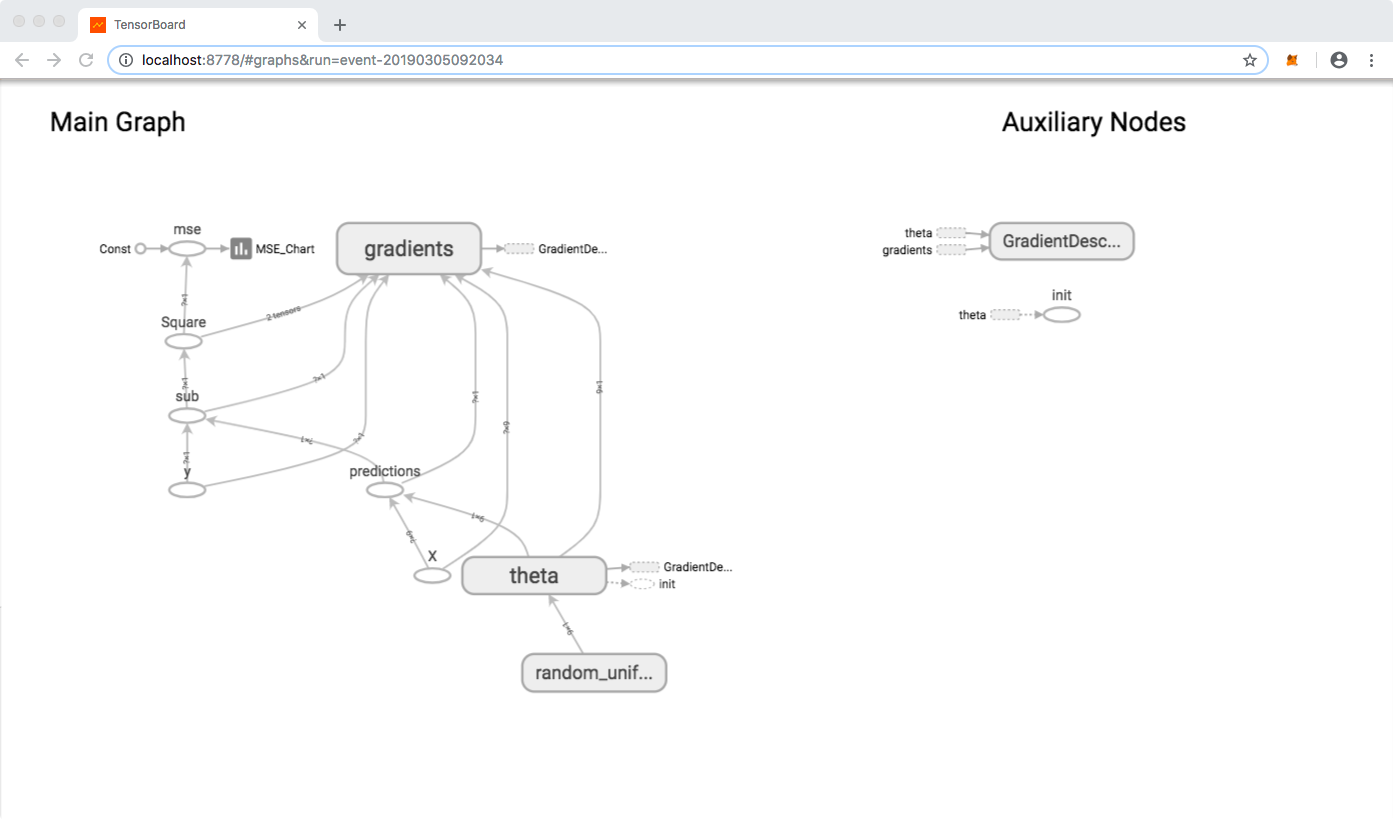

In [24]:
Image(filename='./images/TensorBoard_MSE_MainGraph_Example_v1.png')

In [25]:
print(error.op.name)
print(mse.op.name)

sub
mse


# Name Scopes

In [26]:
from datetime import datetime

currentTime = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_tfLogdir = "tf_logs"
tfLogdir = "{}/event_nscope-{}/".format(root_tfLogdir, currentTime)

# Reset the default graph and use same random seed
reset_graph()

# num_epochs value changed
num_epochs = 1000
learning_rate = 0.01

# Construction phase
X = tf.placeholder(tf.float32, shape=(None, n+1), name="X") # placeholder, X
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")   # placeholder, y

theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed=42), name="theta") # variable, theta
y_pred = tf.matmul(X, theta, name="predictions")

with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

# Prepare an initialization node
init_var = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE_NScope', mse)
file_writer = tf.summary.FileWriter(tfLogdir, tf.get_default_graph())

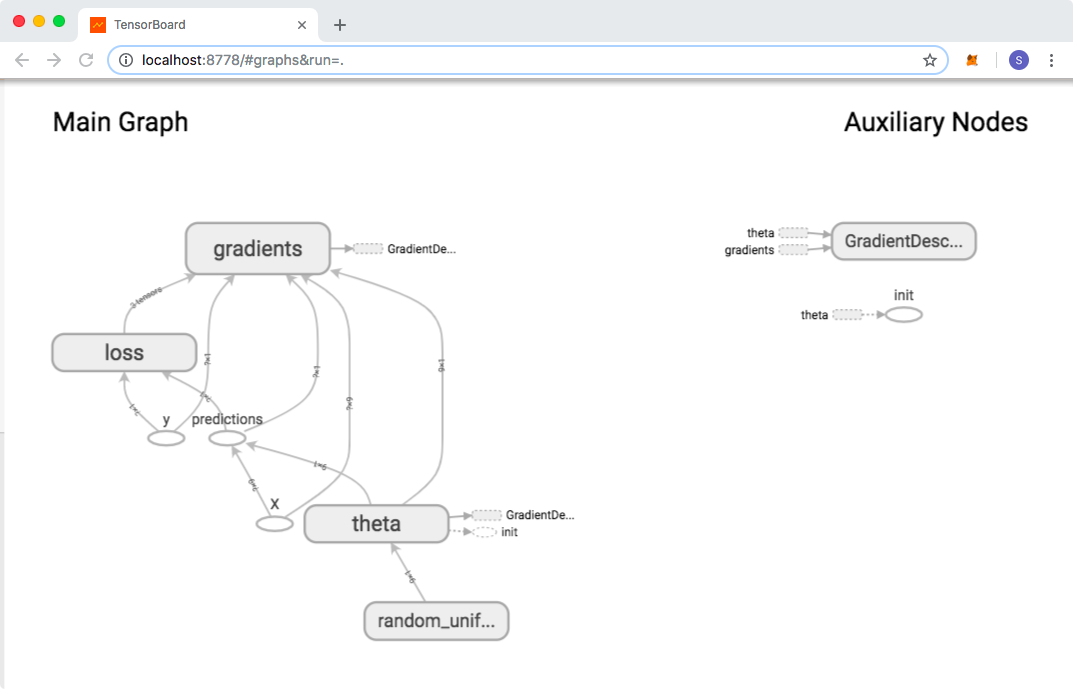

In [27]:
Image(filename='./images/TensorBoard_NameScope_Example.png')

In [28]:
# num_epochs value changed
num_epochs = 10
learning_rate = 0.01
batch_size = 100
num_batches = int(np.ceil(m / batch_size)) # 207

with tf.Session() as cal_housing_minigd_session:
    cal_housing_minigd_session.run(init_var)

    # Need to compute in session
    for epoch in range(num_epochs):
        for batch_index in range(num_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            
            # In every 10 mini-batchs, evaluate the mse_summary node during training
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = (epoch * num_batches) + batch_index
                file_writer.add_summary(summary_str, step)
            cal_housing_minigd_session.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        mse_value = mse.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch", epoch, "MSE =", mse_value)
    
    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("The best theta values from Mini-batch Gradient Descent : \n", best_theta.T)

Epoch 0 MSE = 0.4797648
Epoch 1 MSE = 0.6515882
Epoch 2 MSE = 0.48358238
Epoch 3 MSE = 0.67187047
Epoch 4 MSE = 0.422881
Epoch 5 MSE = 0.49335742
Epoch 6 MSE = 0.34765565
Epoch 7 MSE = 0.3982023
Epoch 8 MSE = 0.6901503
Epoch 9 MSE = 0.37350392
The best theta values from Mini-batch Gradient Descent : 
 [[ 2.0703337   0.8637145   0.12255151 -0.31211874  0.38510373  0.00434168
  -0.01232954 -0.83376896 -0.8030471 ]]


In [29]:
print(error.op.name)
print(mse.op.name)

loss/sub
loss/mse


In [30]:
# More examples on name scopes
reset_graph()

var1 = tf.Variable(0, name="var_a")      # name == "a"
var2 = tf.Variable(0, name="var_a")      # name == "var_a_1"

with tf.name_scope("parameter"):         # name == "param"
    var3 = tf.Variable(0, name="var_a")  # name == "param/a"

with tf.name_scope("parameter"):         # name == "parameter/var_a"
    var4 = tf.Variable(0, name="var_a")  # name == "parameter_1/var_a"

for node in (var1, var2, var3, var4):
    print(node.op.name)

var_a
var_a_1
parameter/var_a
parameter_1/var_a


# Modularity

In [31]:
reset_graph()

# (1) Construction phase
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")

b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z2, 0., name="relu2")

output = tf.add(relu1, relu2, name="output")

# Prepare an initialization node
init_var = tf.global_variables_initializer()

with tf.Session() as tf_SimpleSession:
    tf_SimpleSession.run(init_var)
    output_value = output.eval(feed_dict={X:[[1,2,3]]})
    print("Output : \n", output_value)
    tf_SimpleSession.close()

Output : 
 [[9.668245]]


In [32]:
# Interactive session is automatically set as default session
inter_session = tf.InteractiveSession()

# (2) Execution phase
init_var.run()
interactive_session_result = output.eval(feed_dict={X:[[1,2,3]]})

X_result = X.eval(feed_dict={X:[[1,2,3]]})
w1_result = w1.eval()
print("Value of X :\n", X_result)
print("Value of w1 :\n", w1_result)
print("Shape of X :\n", X_result.shape)

print("Addition of Relu1 and Relu2 via interactive session : ", interactive_session_result)

# (3) Close the session to release resources
inter_session.close()

Value of X :
 [[1. 2. 3.]]
Value of w1 :
 [[-0.56448996]
 [ 3.032917  ]
 [ 1.0119121 ]]
Shape of X :
 (1, 3)
Addition of Relu1 and Relu2 via interactive session :  [[9.668245]]


In [33]:
X.get_shape()

TensorShape([Dimension(None), Dimension(3)])

In [34]:
X = np.matrix([[1, 2, 3], [4, 5, 6]])
X.shape

(2, 3)

In [35]:
reset_graph()

# (1) Construction phase
n_features = 3
X1 = tf.placeholder(tf.float32, shape=(3, n_features), name="X1")

# Interactive session is automatically set as default session
inter_session = tf.InteractiveSession()

# (2) Execution phase
X1_result = X1.eval(feed_dict={X1:[[1,2,3],[4,5,6],[7,8,9]]})

print("Value of X1 :\n", X1_result)
print("Shape of X1 :\n", X1_result.shape)

# (3) Close the session to release resources
inter_session.close()

# TensorShape([Dimension(3), Dimension(3)])
print("Get Shape of X1 after session closed :\n", X1.get_shape())

Value of X1 :
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
Shape of X1 :
 (3, 3)
Get Shape of X1 after session closed :
 (3, 3)


# Relu Modularity with multiple additions

In [36]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1) # X.get_shape()[1] gives Dimension for column
    w = tf.Variable(tf.random_normal(w_shape), name = "weights")
    b = tf.Variable(0.0, name = "bias")
    z = tf.add(tf.matmul(X,w), b, name = "z")
    return tf.maximum(z, 0.0, name = "relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name = "X")
relus = [relu(X) for ctr in range(5)]

# Compute the sum of a list of tensors with add_n()
computed_result = tf.add_n(relus, name = "computed_result")

# Prepare an initialization node
init_var = tf.global_variables_initializer()

file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

with tf.Session() as modularity_session:
    modularity_session.run(init_var)

    # Need to compute in session
    relus_result = computed_result.eval(feed_dict={X:[[1,2,3]]})
    print("Relus result : ", relus_result)

file_writer.flush()
file_writer.close()

Relus result :  [[10.161307]]


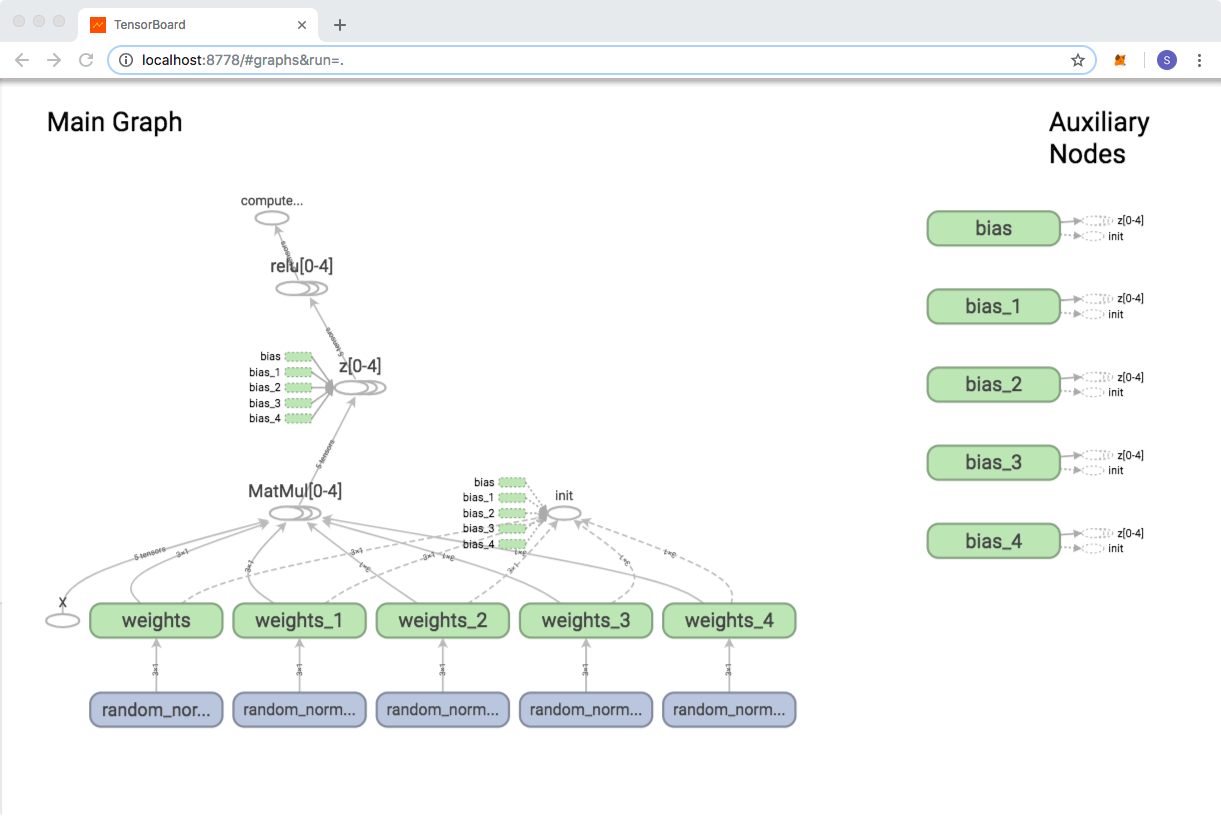

In [37]:
Image(filename='./images/TensorBoard_Modularity_Relu1.png')

# Name-scoped Units : Relu unique names

In [38]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1) # X.get_shape()[1] gives Dimension for column
        w = tf.Variable(tf.random_normal(w_shape), name = "weights")
        b = tf.Variable(0.0, name = "bias")
        z = tf.add(tf.matmul(X,w), b, name = "z")
        return tf.maximum(z, 0.0, name = "max")

# Construction phase
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name = "X")
relus = [relu(X) for ctr in range(5)]

# Compute the sum of a list of tensors with add_n()
reluResult = tf.add_n(relus, name = "reluResult")

# Prepare an initialization node
init_var = tf.global_variables_initializer()

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())

# Execution phase
with tf.Session() as modularity_session:
    modularity_session.run(init_var)

    # Need to compute in session
    relus_result = reluResult.eval(feed_dict={X:[[1,2,3]]})
    print("Relus result : ", relus_result)

file_writer.flush()
file_writer.close()

Relus result :  [[10.161307]]


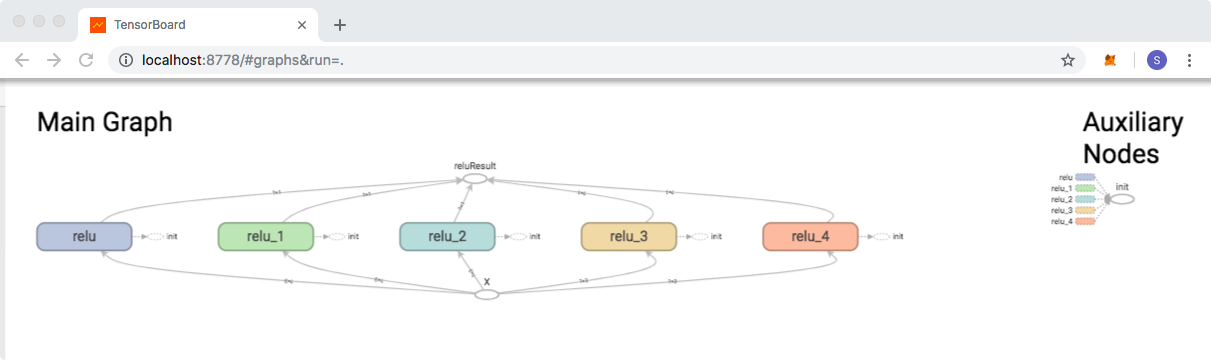

In [39]:
Image(filename='./images/TensorBoard_NameScope_Relu2_v1.png')

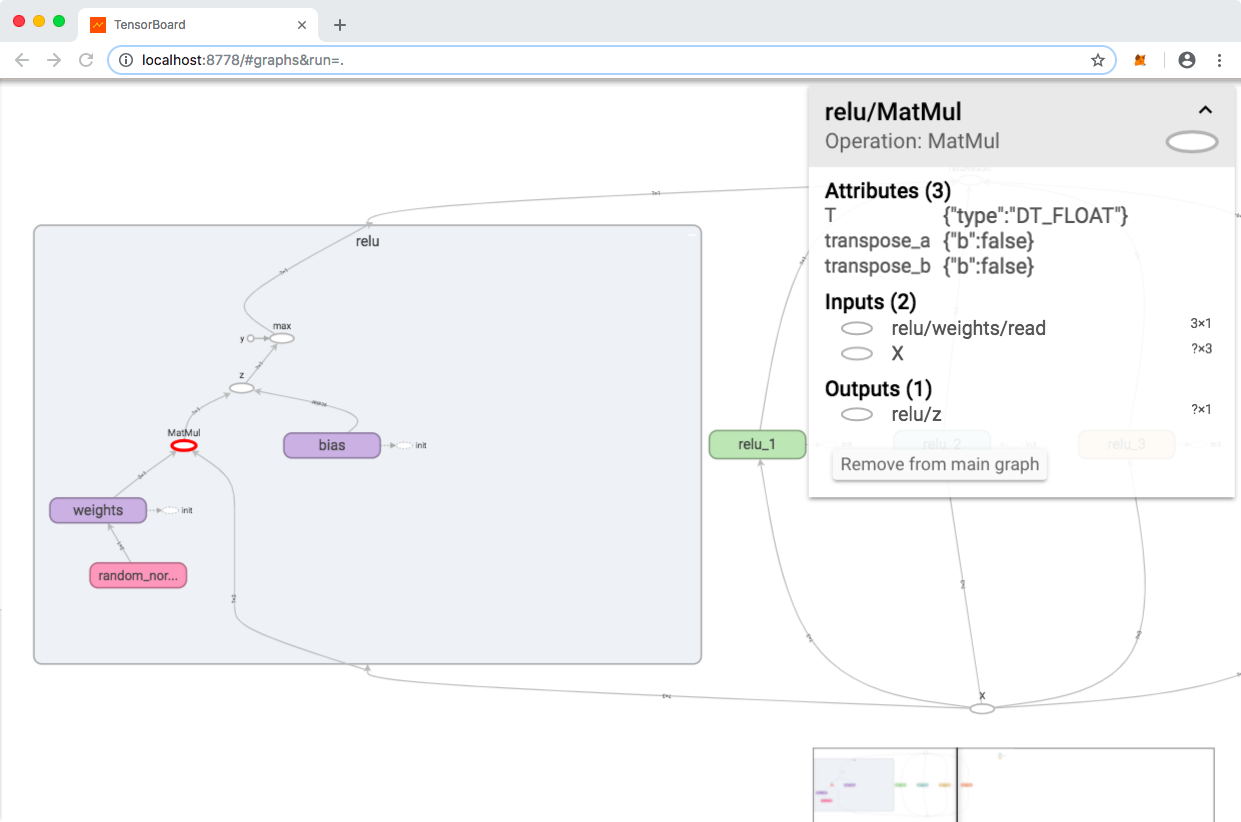

In [40]:
Image(filename='./images/TensorBoard_NameScope_Relu2_v2.png')

# Sharing Variables

Case 1 : Defined parameter and pass to function

In [41]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1) # X.get_shape()[1] gives Dimension for column
        w = tf.Variable(tf.random_normal(w_shape), name = "weights")
        b = tf.Variable(0.0, name = "bias")
        z = tf.add(tf.matmul(X,w), b, name = "z")
        return tf.maximum(z, threshold, name = "max")

# Passing outside defined threshold variable in the classic way as a parameter into the function
threshold = tf.Variable(0.0, name="threshold")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name = "X")
relus = [relu(X, threshold) for ctr in range(5)]

# Compute the sum of a list of tensors with add_n()
reluResult = tf.add_n(relus, name = "reluResult")

Case 2 : set the shared variable as an attribute of the function upon the first call

In [42]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = (int(X.get_shape()[1]), 1) # X.get_shape()[1] gives Dimension for column
        w = tf.Variable(tf.random_normal(w_shape), name = "weights")
        b = tf.Variable(0.0, name = "bias")
        z = tf.add(tf.matmul(X,w), b, name = "z")
        return tf.maximum(z, relu.threshold, name = "max") # scoped attribute

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name = "X")
relus = [relu(X) for ctr in range(5)]

# Compute the sum of a list of tensors with add_n()
reluResult = tf.add_n(relus, name = "reluResult")

Case 3 : Using cleaner option with get_variable() and variable_scope() for sharing variable

In [43]:
reset_graph()

# Create a variable named "relu/threshold" as a scalar with shape=() and initialize with 0.0
with tf.variable_scope("relu"):
    # If variable has been created, get_variable() will raise an exception
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
    
# To reuse a variable, need to explicitly setting the variable scope's reuse attribute to True
# Do not need to specify the shape or the initializer
with tf.variable_scope("relu", reuse=True):
    # If variable does not exist or it has not been created, get_variable() will raise an exception
    threshold = tf.get_variable("threshold")
    
with tf.variable_scope("relu") as scope:
    # Set reuse attribute to True
    scope.reuse_variables()
    # If variable does not exist or it has not been created, get_variable() will raise an exception
    threshold = tf.get_variable("threshold")

Access the threshold parameter without having to pass it as a parameter

In [44]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold") # reuse existing variable
        w_shape = (int(X.get_shape()[1]), 1) # X.get_shape()[1] gives Dimension for column
        w = tf.Variable(tf.random_normal(w_shape), name = "weights")
        b = tf.Variable(0.0, name = "bias")
        z = tf.add(tf.matmul(X,w), b, name = "z")
        return tf.maximum(z, threshold, name = "max")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name = "X")

with tf.variable_scope("relu"):
    # Create the threshold variable and initialize to 0.0
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))

# reuses the relu/threshold variables and create the other ReLu nodes
relus = [relu(X) for relu_idx in range(5)]

# Compute the sum of a list of tensors with add_n()
reluResult = tf.add_n(relus, name = "reluResult")

# Prepare an initialization node
init_var = tf.global_variables_initializer()

file_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())

# Execution phase
with tf.Session() as relu6_modularity_session:
    relu6_modularity_session.run(init_var)

    # Need to compute in session
    relus_result = reluResult.eval(feed_dict={X:[[1,2,3]]})
    print("Relus result : ", relus_result)

file_writer.flush()
file_writer.close()

Relus result :  [[7.185649]]


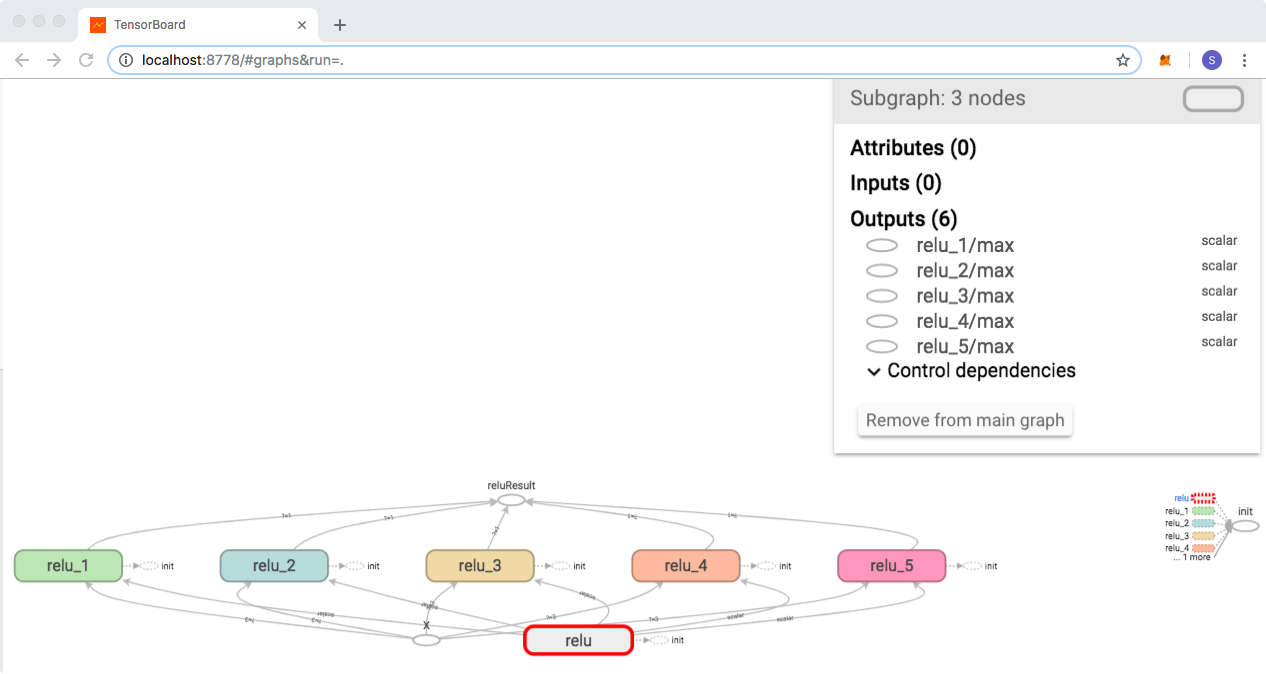

In [45]:
Image(filename='./images/TensorBoard_Relu6_Reuse_v1.png')

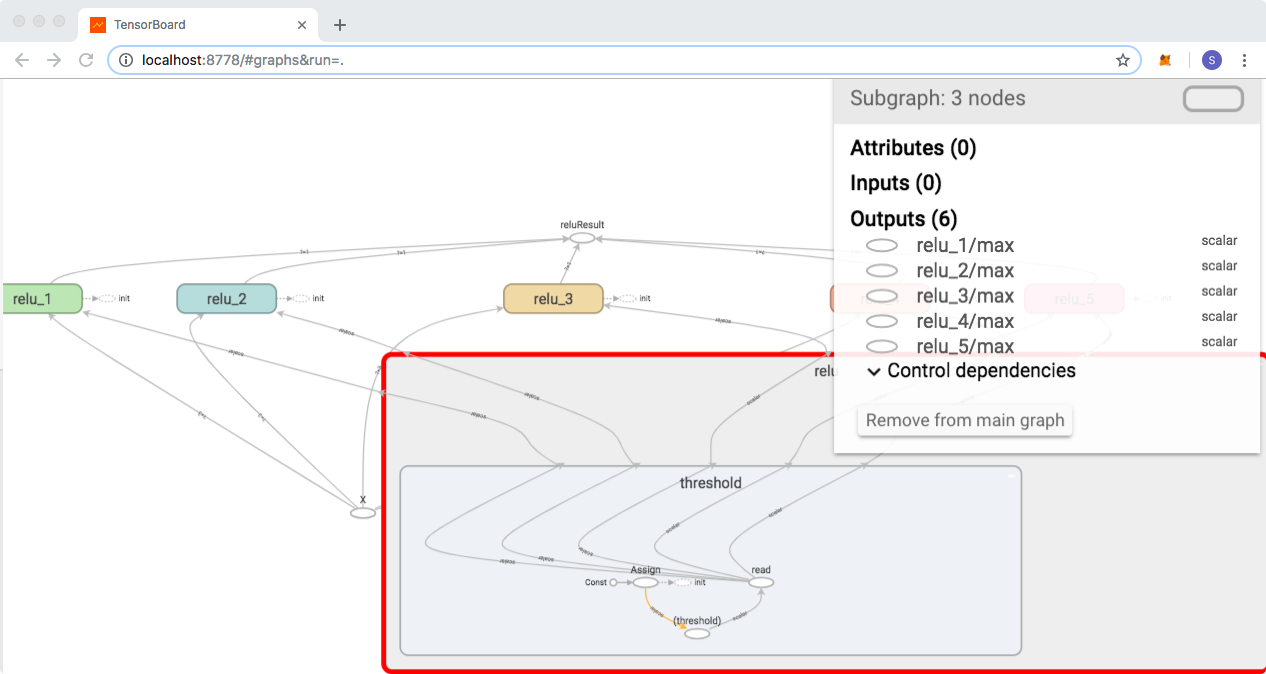

In [46]:
Image(filename='./images/TensorBoard_Relu6_Reuse_v2.png')

Defining variable within function to be reused; get_variable creates or reuses the variable.  Set <b>"reuse=None"</b> on the first call and <b>"reuse=True"</b> for the other calls.  The shared variable lives within the first ReLU.

In [47]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1) # X.get_shape()[1] gives Dimension for column
    w = tf.Variable(tf.random_normal(w_shape), name = "weights")
    b = tf.Variable(0.0, name = "bias")
    z = tf.add(tf.matmul(X,w), b, name = "z")
    return tf.maximum(z, threshold, name = "max")
    
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name = "X")
relus = []

for relu_idx in range(5):
    with tf.variable_scope("relu", reuse=(relu_idx >= 1 or None)) as scope:
        relus.append(relu(X))

# Compute the sum of a list of tensors with add_n()
reluResult = tf.add_n(relus, name = "reluResult")

# Prepare an initialization node
init_var = tf.global_variables_initializer()

file_writer = tf.summary.FileWriter("logs/relu7", tf.get_default_graph())

# Execution phase
with tf.Session() as relu7_modularity_session:
    relu7_modularity_session.run(init_var)

    # Need to compute in session
    relus_result = reluResult.eval(feed_dict={X:[[1,2,3]]})
    print("Relus result : ", relus_result)

file_writer.flush()
file_writer.close()

Relus result :  [[7.185649]]


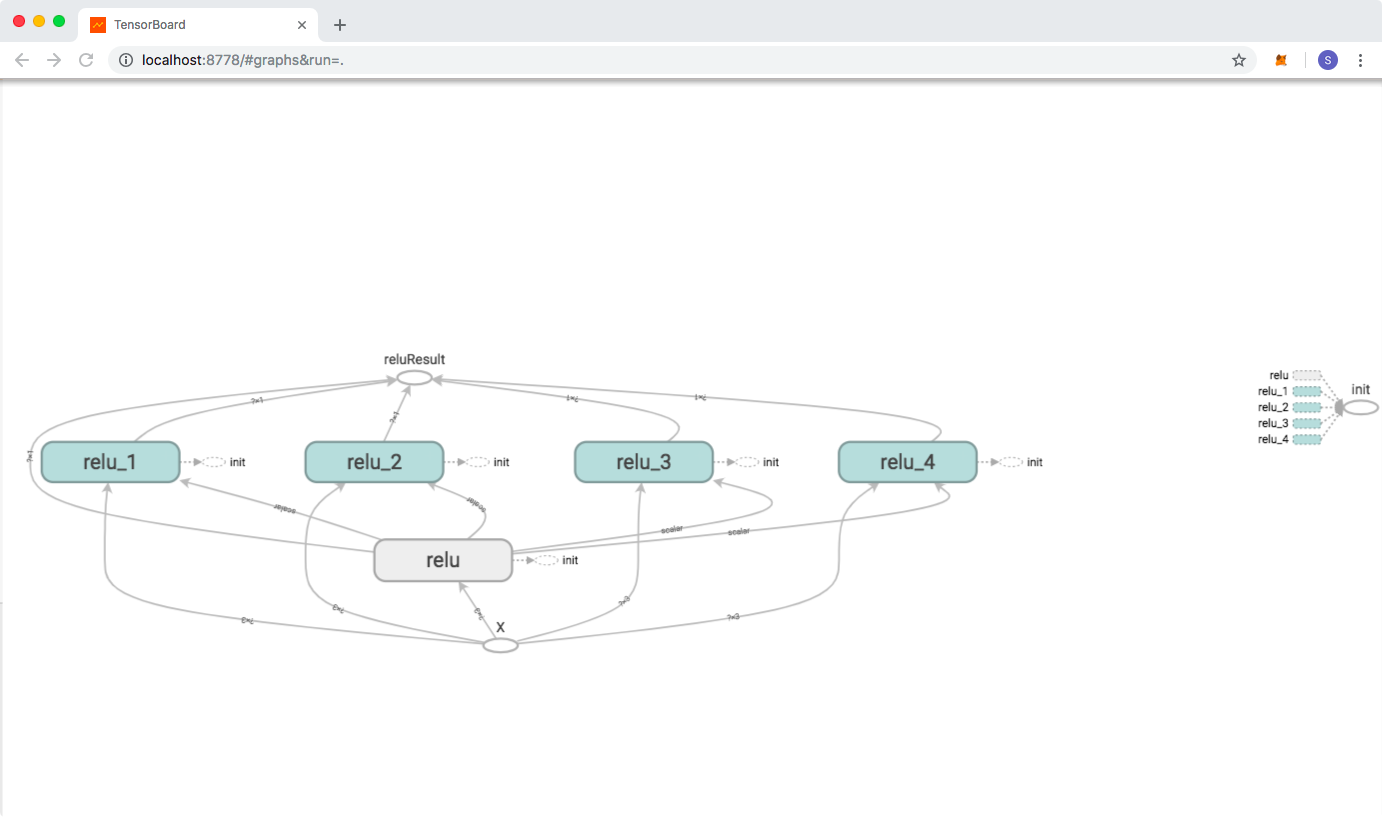

In [48]:
Image(filename='./images/TensorBoard_Relu7_Reuse_v1.png')

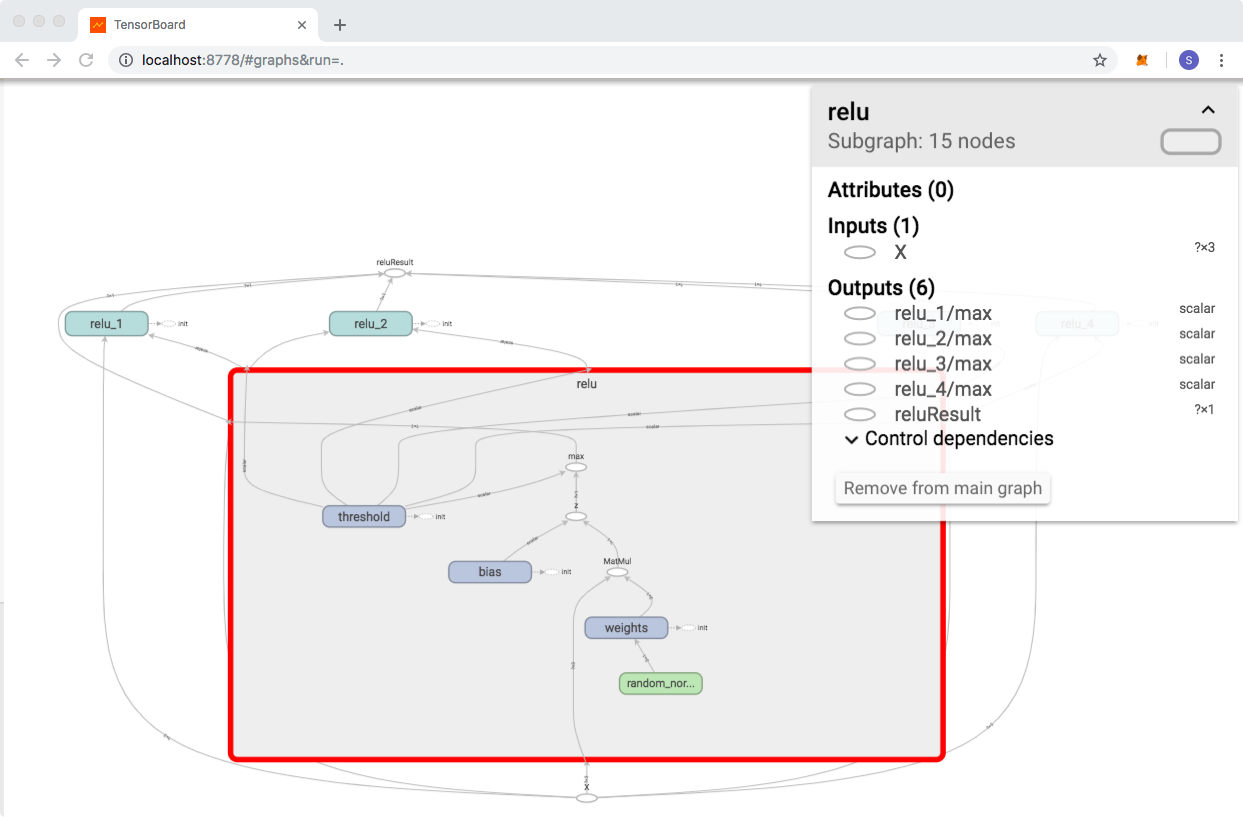

In [49]:
Image(filename='./images/TensorBoard_Relu7_Reuse_v2.png')